In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
import mne
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf


**Load data from csv files.**

In [3]:
df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_S_feature.csv", header = 0)

<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:1: SyntaxWarning: invalid escape sequence '\F'
  df_A = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_A_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:2: SyntaxWarning: invalid escape sequence '\F'
  df_M = pd.read_csv("C:/SEAN/GA Tech Academics/Grad\Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Classification/Stress/Datasets/F_Relax_M_feature.csv", header = 0)
C:\Users\sean\AppData\Local\Temp\ipykernel_9260\3915618476.py:3: SyntaxWarning: invalid escape sequence '\F'
  df_S = pd.read_csv("C:/SEAN/GA Tech Academics/Gra

In [4]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 450)
(6000, 450)
(6000, 450)


**Do some basic data preprocessing before performing feature selection.**

Fill in missing data with the mode of its column.

In [5]:
df_A = df_A.fillna(df_A.mode().iloc[0])
df_M = df_M.fillna(df_M.mode().iloc[0])
df_S = df_S.fillna(df_S.mode().iloc[0])

Drop the leftmost column of each dataframe because it is just an ID number.

In [6]:
df_A = df_A.iloc[:, 1:] 
df_M = df_M.iloc[:, 1:]
df_S = df_S.iloc[:, 1:]

In [7]:
print(df_A.shape)
print(df_M.shape)
print(df_S.shape)

(6000, 449)
(6000, 449)
(6000, 449)


**Feature selection:**

In [18]:
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float) -> pd.DataFrame:
    print("----------STARTING FEATURE SELECTION----------")
    y = df.iloc[:, -1]
    
    # Use recursive feature elimination with cross validation to reduce the dimensionality of the data for each EEG cap channel.
    
    print("----------STARTING RECURSIVE FEATURE ELIMINATION----------")
    start_column_index = 0
    num_features_kept_rfe = 0
    kept_columns_rfe = [] # list of names of columns that are kept

    for i in range(32):
        #print("EEG Cap Channel #", i)
        # Ignore the ratios (e.g. theta-beta ratio)
        X = df.iloc[:, list(range(start_column_index, start_column_index + 5)) + list(range(start_column_index + 8, start_column_index + 14))]
        curr_columns = X.columns
        
        # decision tree classifier
        dt_classifier = DecisionTreeClassifier() # Note: The features are randomly permuted. For deterministic results, set random_state to a fixed integer.
        # recursive feature elimination with cross validation
        rfecv = RFECV(estimator = dt_classifier, min_features_to_select = 1, cv = StratifiedKFold(), scoring = 'accuracy')
        rfecv.fit(X, y)
        
        # Track the kept features
        kept_columns_rfe.extend(curr_columns[rfecv.support_])
        num_features_kept_rfe += rfecv.n_features_
        
        #print("Optimal number of features : %d" % rfecv.n_features_)
        #print("Columns kept in this iteration:", curr_columns[rfecv.support_])
        
        start_column_index += 14
    print("----------FINISHED RECURSIVE FEATURE ELIMINATION----------")
    
    df_after_rfe = df[kept_columns_rfe]
    print("number of features kept after recursive feature elimination:", num_features_kept_rfe)
    
    X = df_after_rfe
    curr_columns = X.columns

    # Use PCA to further reduce the dimensionality of the dataset.
    print("----------STARTING PCA----------")
    # Scale the data.
    scaler = StandardScaler()
    scaler.fit(X)
    scaled_X= scaler.transform(X)

    # Perform PCA
    pca = PCA(n_components = 50)
    pca.fit(scaled_X)
    pca_result = pca.transform(scaled_X)
    print("----------FINISHED PCA----------")
    
    # Determine number of components needed to keep a certain threshold percentage of variance

    explained_variance_ratio = pca.explained_variance_ratio_
    #print("explained variance ratio: ", explained_variance_ratio)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    #print("cumulative variance ratio: ", cumulative_variance_ratio)
    #print(cumulative_variance_ratio >= 0.8)
    num_pc = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print("Number of principal components to keep", variance_threshold * 100, "% of variance:", num_pc)

    # Visualization
    plt.figure(figsize=(8, 6))

    # Line plot for cumulative explained variance (all points are initially red)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red', label='Cumulative explained variance', linestyle='-')

    # Use blue dots to denote every n-th point where n is divisible by 5
    for i in range(5, len(cumulative_variance_ratio) + 1, 5):
        plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xlabel('# of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.show()
    
    # Find components that give the variance threshold.
    
    components_for_threshold = np.where(cumulative_variance_ratio >= variance_threshold)[0][0] + 1

    # Get the list of column names needed to reach the variance threshold.
    needed_columns = curr_columns[:components_for_threshold]
    # print("Columns needed for", threshold * 100, "% explained variance:")
    # print(needed_columns)
    print("final kept columns:")
    print(df[needed_columns].head())
    print("----------FINISHED FEATURE SELECTION----------")
    return df[needed_columns]

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 184
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 23


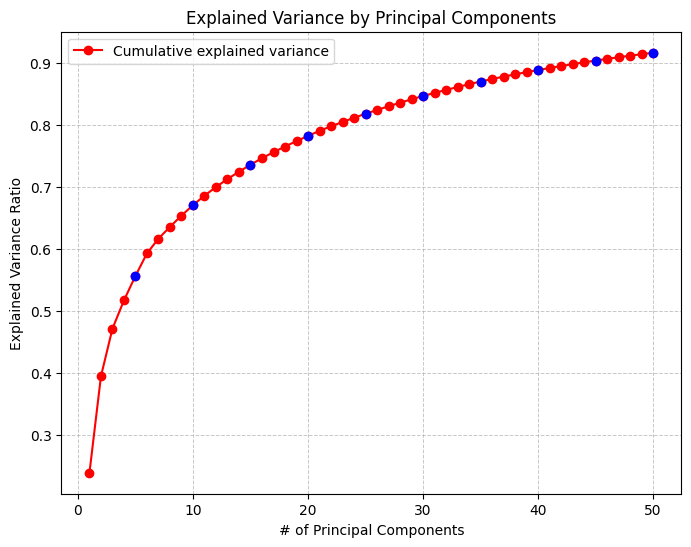

final kept columns:
    0.psd_delta   0.psd_theta  0.psd_alpha   0.psd_beta  0.psd_gamma  \
0  14850.830823  14923.215094  7910.065985  6950.560915  3047.582095   
1  14838.280527  18650.065251  7921.853628  8087.625726  2855.607519   
2   7143.715839  16263.647994  6245.775968  4200.151132  2838.155117   
3   7143.570136  12413.634950  7677.763201  4200.428316  2764.924613   
4  19573.432251  18451.900407  7663.019348  6509.398324  2423.619039   

   0.spectral_entropy_value  0.delta_rel_power  0.theta_rel_power  \
0                  4.911304           0.059237           0.199444   
1                  4.778889           0.150847           0.134471   
2                  4.455605           0.082685           0.319816   
3                  4.594508           0.032636           0.173594   
4                  4.605586           0.198891           0.162208   

   0.alpha_rel_power  0.beta_rel_power  ...   1.psd_beta  1.psd_gamma  \
0           0.183638          0.249854  ...  5824.969235  2

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.delta_rel_power,0.theta_rel_power,0.alpha_rel_power,0.beta_rel_power,...,1.psd_beta,1.psd_gamma,1.spectral_entropy_value,1.delta_rel_power,1.theta_rel_power,1.alpha_rel_power,1.beta_rel_power,2.psd_delta,2.psd_theta,2.psd_alpha
0,14850.830823,14923.215094,7910.065985,6950.560915,3047.582095,4.911304,0.059237,0.199444,0.183638,0.249854,...,5824.969235,2661.371734,4.704152,0.060570,0.199646,0.106258,0.339591,8039.972356,10515.873942,4416.116832
1,14838.280527,18650.065251,7921.853628,8087.625726,2855.607519,4.778889,0.150847,0.134471,0.107598,0.363278,...,6269.167711,2220.615506,4.884465,0.103855,0.126185,0.091360,0.441606,2524.927423,9608.824749,3048.655786
2,7143.715839,16263.647994,6245.775968,4200.151132,2838.155117,4.455605,0.082685,0.319816,0.088251,0.175097,...,3878.494666,2121.399887,4.622914,0.126962,0.301774,0.110384,0.240772,11914.922522,16710.419354,4748.160067
3,7143.570136,12413.634950,7677.763201,4200.428316,2764.924613,4.594508,0.032636,0.173594,0.122696,0.187016,...,3844.336500,2656.750004,4.636538,0.103653,0.057890,0.126795,0.215361,7769.417844,4775.209063,6162.503482
4,19573.432251,18451.900407,7663.019348,6509.398324,2423.619039,4.605586,0.198891,0.162208,0.083558,0.484568,...,4717.883216,2949.386556,4.664318,0.203946,0.110838,0.096200,0.344172,18421.953705,14419.819060,5892.507883


In [34]:
df_A_preprocessed = perform_feature_selection(df = df_A, variance_threshold=0.8)
df_A_preprocessed.head()

In [35]:
df_A_y = df_A.iloc[:, -1]
df_A_preprocessed = pd.concat([df_A_preprocessed, df_A_y], axis=1)
df_A_preprocessed.to_csv('Datasets/df_A_preprocessed.csv', index = False)

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 152
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 22


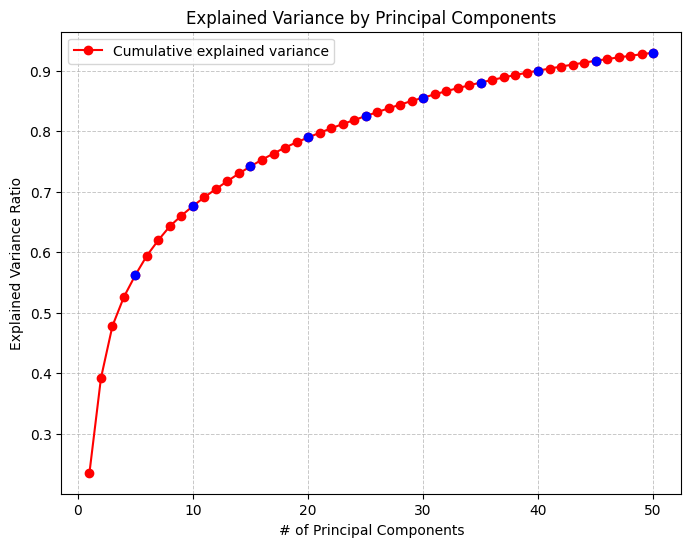

final kept columns:
    0.psd_delta   1.psd_delta    1.psd_beta   2.psd_delta  \
0  28147.941302  31541.470105  12347.953811  34938.513792   
1  22618.036566  39936.522448  20171.707479  36819.225771   
2  43601.788099  64146.785166  18628.786426  66980.080825   
3  42496.747857  33907.780297  15681.375821  26387.037209   
4  26204.813555  37629.361928  21883.692721  46289.794364   

   2.spectral_entropy_value   3.psd_delta   3.psd_theta   3.psd_alpha  \
0                  4.922720  40310.063187  29293.163879  23058.933670   
1                  4.849991  16153.754973  25837.083367  24192.407129   
2                  5.046028  36703.748590  33080.101368  20292.144744   
3                  4.993238  27658.844197  46686.886989  11399.514029   
4                  4.079599  31533.059501  16769.571623  10446.491096   

     3.psd_beta   3.psd_gamma  ...  3.delta_rel_power  3.theta_rel_power  \
0  13218.574772  12905.214379  ...           0.133566           0.079917   
1  16700.775874  13629

,0.psd_delta,1.psd_delta,1.psd_beta,2.psd_delta,2.spectral_entropy_value,3.psd_delta,3.psd_theta,3.psd_alpha,3.psd_beta,3.psd_gamma,...,3.delta_rel_power,3.theta_rel_power,3.alpha_rel_power,3.beta_rel_power,4.psd_alpha,4.psd_gamma,5.psd_delta,5.psd_alpha,5.psd_beta,5.alpha_rel_power
0,28147.941302,31541.470105,12347.953811,34938.513792,4.922720,40310.063187,29293.163879,23058.933670,13218.574772,12905.214379,...,0.133566,0.079917,0.143573,0.286159,18965.198627,9528.718253,16370.231319,13767.001272,5853.442135,0.152225
1,22618.036566,39936.522448,20171.707479,36819.225771,4.849991,16153.754973,25837.083367,24192.407129,16700.775874,13629.804908,...,0.071854,0.074107,0.121929,0.357124,13077.775287,7976.422647,11010.032631,6198.527169,9502.346494,0.045701
2,43601.788099,64146.785166,18628.786426,66980.080825,5.046028,36703.748590,33080.101368,20292.144744,20924.417016,7833.194308,...,0.140543,0.138719,0.088020,0.440160,18216.623258,7330.350069,14589.011408,13617.609789,9981.125948,0.066662
3,42496.747857,33907.780297,15681.375821,26387.037209,4.993238,27658.844197,46686.886989,11399.514029,16751.662167,10801.569649,...,0.054072,0.196874,0.028740,0.377961,17124.681107,8570.896216,17022.803496,8836.577200,6813.136935,0.097449
4,26204.813555,37629.361928,21883.692721,46289.794364,4.079599,31533.059501,16769.571623,10446.491096,14977.832168,17267.127667,...,0.076085,0.014380,0.031495,0.175952,7261.552744,11341.236550,11827.793849,3019.109910,8757.088312,0.031590


In [36]:
df_M_preprocessed = perform_feature_selection(df = df_M, variance_threshold=0.8)
df_M_preprocessed.head()

In [37]:
df_M_y = df_M.iloc[:, -1]
df_M_preprocessed = pd.concat([df_M_preprocessed, df_M_y], axis=1)
df_M_preprocessed.to_csv('Datasets/df_M_preprocessed.csv', index = False)

----------STARTING FEATURE SELECTION----------
----------STARTING RECURSIVE FEATURE ELIMINATION----------
----------FINISHED RECURSIVE FEATURE ELIMINATION----------
number of features kept after recursive feature elimination: 208
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 80.0 % of variance: 23


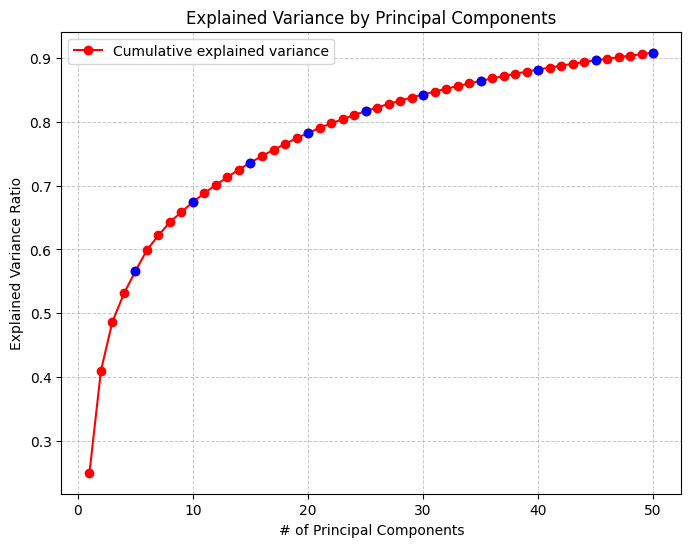

final kept columns:
    0.psd_delta  0.beta_rel_power   1.psd_delta   1.psd_theta  1.psd_alpha  \
0   9994.605340          0.355683   9257.775317   7265.036422  7690.433996   
1  14145.852129          0.280880  10435.260425   3644.720023  2613.103811   
2  10178.565631          0.233491   4620.447414  10058.027260  7519.625489   
3  16698.788741          0.210519  17008.405306   2634.528149  7967.808412   
4   5514.739540          0.287536   5870.110121   9069.907815  6995.540680   

    1.psd_beta  1.psd_gamma  1.spectral_entropy_value  1.delta_rel_power  \
0  5163.761781  1918.183035                  4.939184           0.135241   
1  2299.748262   801.173730                  4.803097           0.218845   
2  4332.200640   923.418221                  4.710522           0.061643   
3  3832.212650   977.771965                  4.304630           0.300044   
4  3168.696298   760.198454                  4.495017           0.066728   

   1.alpha_rel_power  ...   3.psd_delta   3.psd_theta 

,0.psd_delta,0.beta_rel_power,1.psd_delta,1.psd_theta,1.psd_alpha,1.psd_beta,1.psd_gamma,1.spectral_entropy_value,1.delta_rel_power,1.alpha_rel_power,...,3.psd_delta,3.psd_theta,3.psd_beta,3.psd_gamma,3.spectral_entropy_value,3.delta_rel_power,4.psd_delta,4.psd_theta,4.psd_alpha,4.psd_beta
0,9994.605340,0.355683,9257.775317,7265.036422,7690.433996,5163.761781,1918.183035,4.939184,0.135241,0.114774,...,9661.907784,7575.225647,3342.981295,1164.149455,4.803705,0.227786,11962.079743,7616.719576,8555.264679,2759.863513
1,14145.852129,0.280880,10435.260425,3644.720023,2613.103811,2299.748262,801.173730,4.803097,0.218845,0.126965,...,9912.301749,5373.831486,3596.341318,1112.545877,4.744306,0.153162,12246.281783,6463.806082,5523.576530,4268.471560
2,10178.565631,0.233491,4620.447414,10058.027260,7519.625489,4332.200640,923.418221,4.710522,0.061643,0.163435,...,6328.599401,14417.491932,4935.154761,675.216528,4.611128,0.069946,7910.185855,18249.910520,7116.787168,4956.644722
3,16698.788741,0.210519,17008.405306,2634.528149,7967.808412,3832.212650,977.771965,4.304630,0.300044,0.180555,...,12758.430345,4609.960682,3178.899497,946.701929,4.285764,0.214107,11628.322260,8135.949233,15869.530564,3122.330885
4,5514.739540,0.287536,5870.110121,9069.907815,6995.540680,3168.696298,760.198454,4.495017,0.066728,0.329012,...,6800.785099,9707.288972,3032.801001,933.091253,4.556705,0.056195,6754.787865,9977.967308,11733.082895,3283.993904


In [38]:
df_S_preprocessed = perform_feature_selection(df = df_S, variance_threshold=0.8)
df_S_preprocessed.head()

In [39]:
df_S_y = df_S.iloc[:, -1]
df_S_preprocessed = pd.concat([df_S_preprocessed, df_S_y], axis=1)
df_S_preprocessed.to_csv('Datasets/df_S_preprocessed.csv', index = False)

**Implement the decision tree for detecting stress levels.**

In [41]:
df_A_preprocessed.head()

,0.psd_delta,0.psd_theta,0.psd_alpha,0.psd_beta,0.psd_gamma,0.spectral_entropy_value,0.delta_rel_power,0.theta_rel_power,0.alpha_rel_power,0.beta_rel_power,...,1.psd_gamma,1.spectral_entropy_value,1.delta_rel_power,1.theta_rel_power,1.alpha_rel_power,1.beta_rel_power,2.psd_delta,2.psd_theta,2.psd_alpha,Stress_level
0,14850.830823,14923.215094,7910.065985,6950.560915,3047.582095,4.911304,0.059237,0.199444,0.183638,0.249854,...,2661.371734,4.704152,0.060570,0.199646,0.106258,0.339591,8039.972356,10515.873942,4416.116832,1
1,14838.280527,18650.065251,7921.853628,8087.625726,2855.607519,4.778889,0.150847,0.134471,0.107598,0.363278,...,2220.615506,4.884465,0.103855,0.126185,0.091360,0.441606,2524.927423,9608.824749,3048.655786,1
2,7143.715839,16263.647994,6245.775968,4200.151132,2838.155117,4.455605,0.082685,0.319816,0.088251,0.175097,...,2121.399887,4.622914,0.126962,0.301774,0.110384,0.240772,11914.922522,16710.419354,4748.160067,1
3,7143.570136,12413.634950,7677.763201,4200.428316,2764.924613,4.594508,0.032636,0.173594,0.122696,0.187016,...,2656.750004,4.636538,0.103653,0.057890,0.126795,0.215361,7769.417844,4775.209063,6162.503482,1
4,19573.432251,18451.900407,7663.019348,6509.398324,2423.619039,4.605586,0.198891,0.162208,0.083558,0.484568,...,2949.386556,4.664318,0.203946,0.110838,0.096200,0.344172,18421.953705,14419.819060,5892.507883,1


In [42]:
df_M_preprocessed.head()

,0.psd_delta,1.psd_delta,1.psd_beta,2.psd_delta,2.spectral_entropy_value,3.psd_delta,3.psd_theta,3.psd_alpha,3.psd_beta,3.psd_gamma,...,3.theta_rel_power,3.alpha_rel_power,3.beta_rel_power,4.psd_alpha,4.psd_gamma,5.psd_delta,5.psd_alpha,5.psd_beta,5.alpha_rel_power,Stress_level
0,28147.941302,31541.470105,12347.953811,34938.513792,4.922720,40310.063187,29293.163879,23058.933670,13218.574772,12905.214379,...,0.079917,0.143573,0.286159,18965.198627,9528.718253,16370.231319,13767.001272,5853.442135,0.152225,1
1,22618.036566,39936.522448,20171.707479,36819.225771,4.849991,16153.754973,25837.083367,24192.407129,16700.775874,13629.804908,...,0.074107,0.121929,0.357124,13077.775287,7976.422647,11010.032631,6198.527169,9502.346494,0.045701,1
2,43601.788099,64146.785166,18628.786426,66980.080825,5.046028,36703.748590,33080.101368,20292.144744,20924.417016,7833.194308,...,0.138719,0.088020,0.440160,18216.623258,7330.350069,14589.011408,13617.609789,9981.125948,0.066662,1
3,42496.747857,33907.780297,15681.375821,26387.037209,4.993238,27658.844197,46686.886989,11399.514029,16751.662167,10801.569649,...,0.196874,0.028740,0.377961,17124.681107,8570.896216,17022.803496,8836.577200,6813.136935,0.097449,1
4,26204.813555,37629.361928,21883.692721,46289.794364,4.079599,31533.059501,16769.571623,10446.491096,14977.832168,17267.127667,...,0.014380,0.031495,0.175952,7261.552744,11341.236550,11827.793849,3019.109910,8757.088312,0.031590,1


In [43]:
df_S_preprocessed.head()

,0.psd_delta,0.beta_rel_power,1.psd_delta,1.psd_theta,1.psd_alpha,1.psd_beta,1.psd_gamma,1.spectral_entropy_value,1.delta_rel_power,1.alpha_rel_power,...,3.psd_theta,3.psd_beta,3.psd_gamma,3.spectral_entropy_value,3.delta_rel_power,4.psd_delta,4.psd_theta,4.psd_alpha,4.psd_beta,Stress_level
0,9994.605340,0.355683,9257.775317,7265.036422,7690.433996,5163.761781,1918.183035,4.939184,0.135241,0.114774,...,7575.225647,3342.981295,1164.149455,4.803705,0.227786,11962.079743,7616.719576,8555.264679,2759.863513,1
1,14145.852129,0.280880,10435.260425,3644.720023,2613.103811,2299.748262,801.173730,4.803097,0.218845,0.126965,...,5373.831486,3596.341318,1112.545877,4.744306,0.153162,12246.281783,6463.806082,5523.576530,4268.471560,1
2,10178.565631,0.233491,4620.447414,10058.027260,7519.625489,4332.200640,923.418221,4.710522,0.061643,0.163435,...,14417.491932,4935.154761,675.216528,4.611128,0.069946,7910.185855,18249.910520,7116.787168,4956.644722,1
3,16698.788741,0.210519,17008.405306,2634.528149,7967.808412,3832.212650,977.771965,4.304630,0.300044,0.180555,...,4609.960682,3178.899497,946.701929,4.285764,0.214107,11628.322260,8135.949233,15869.530564,3122.330885,1
4,5514.739540,0.287536,5870.110121,9069.907815,6995.540680,3168.696298,760.198454,4.495017,0.066728,0.329012,...,9707.288972,3032.801001,933.091253,4.556705,0.056195,6754.787865,9977.967308,11733.082895,3283.993904,1


**Idea: We have 3 datasets, each with a different number of columns. I'm thinking about aggregating their individual decision trees into a random FOREST.**

**Train each decision tree individually.**

In [82]:
def train_decision_tree(df: pd.DataFrame) -> tree.DecisionTreeClassifier:
    # Split the dataset (80% train, 20% test)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True) 
    scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    # X_test_scaled = scaler.transform(X_test)
    
    clf = tree.DecisionTreeClassifier()
    
    # Hyperparameter tuning (with GridSearchCV)
    # depth_params = {
    #     'max_depth': [3, 5, 7, 10, 12, 15, 18, 20, 21, 22],
    #     'min_samples_split': [2, 5, 10, 15, 20, 21, 22],
    #     'min_samples_leaf': [1, 3, 5, 8, 10]
    # }
    # grid_search = GridSearchCV(estimator = clf, param_grid = depth_params, scoring='accuracy', cv = 10)
    # grid_search.fit(X_train, y_train)
    # best_clf = grid_search.best_estimator_
    clf.fit(X_train, y_train)
    
    # Evaluate on the test set
    y_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Optimized Decision Tree Test Accuracy: {test_accuracy}")
    #print(f"Best Parameters: {grid_search.best_params_}")
    
    return clf

In [92]:
def train_random_forest(df: pd.DataFrame) -> RandomForestClassifier:
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    # Hyperparameter tuning for RandomForest
    rf = RandomForestClassifier()
    param_grid = {
        'n_estimators': [50, 75, 100, 125, 150],
        'max_depth': [5, 10, 15, 20],
        # 'min_samples_split': [2, 3, 4],
        # 'min_samples_leaf': [1, 2, 4],
        # 'bootstrap': [True, False]
    }
    
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_rf = grid_search.best_estimator_

    # Evaluate on the test set
    y_pred = best_rf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Optimized Random Forest Test Accuracy: {test_accuracy}")
    print(f"Best Parameters: {grid_search.best_params_}")
    
    return best_rf

In [85]:
dt_S = train_decision_tree(df_S_preprocessed)

Optimized Decision Tree Test Accuracy: 0.5375


In [93]:
rf_A = train_random_forest(df_A_preprocessed)

Optimized Random Forest Test Accuracy: 0.595
Best Parameters: {'max_depth': 15, 'n_estimators': 100}


**MAYBE COME BACK LATER TO THIS?**

Preprocess the data (There are 32 electrodes and 450 columns total, so 14 columns per electrode).

PCA: https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

FFS: https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/


In [5]:
def preprocess(data: pd.DataFrame) -> pd.DataFrame: # COME BACK LATER
    data_arr = (data.to_numpy()).T
    channel_names = list(df_A.columns)  
    channel_types = ['eeg'] * len(channel_names) 
    info = mne.create_info(ch_names = channel_names, ch_types = channel_types)
    raw_arr = mne.io.RawArray(data_arr, info)
    raw_arr.filter(1, 40)
    
    # Perform ICA 
    ica = mne.preprocessing.ICA(n_components = 3)
    ica.fit(raw_arr)
    ica.exclude = ica.find_bads_eog(raw_arr)[0]
    raw_ica_cleaned = ica.apply(raw_arr.copy())
    
    # Convert cleaned data back into pandas DataFrame
    processed_data = (raw_ica_cleaned.get_data()).T
    df_processed = pd.DataFrame(processed_data, columns = channel_names)
    raw_ica_cleaned.plot()
    return df_processed
    